In [65]:
import pandas as pd
pd.set_option('display.max_columns', 500)

# 历史天气部分

## 将经纬度找到指定的county

In [66]:
historical_weather = pd.read_csv("../data/historical_weather.csv",parse_dates=['datetime'])
historical_weather['year'] = historical_weather['datetime'].apply(lambda x: x.year)
historical_weather['month'] = historical_weather['datetime'].apply(lambda x: x.month)
historical_weather['day'] = historical_weather['datetime'].apply(lambda x: x.day)
historical_weather['hour'] = historical_weather['datetime'].apply(lambda x: x.hour)
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,year,month,day,hour
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1,2021,9,1,0
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1,2021,9,1,0
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1,2021,9,1,0
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1,2021,9,1,0
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637,2023,5,30,10
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637,2023,5,30,10
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637,2023,5,30,10
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637,2023,5,30,10


In [67]:
historical_weather['latitude'] = historical_weather['latitude'].astype(float).round(1)
historical_weather['longitude'] = historical_weather['longitude'].astype(float).round(1)
historical_weather

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,year,month,day,hour
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1,2021,9,1,0
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1,2021,9,1,0
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1,2021,9,1,0
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1,2021,9,1,0
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,59.7,26.2,637,2023,5,30,10
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,59.7,26.7,637,2023,5,30,10
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,59.7,27.2,637,2023,5,30,10
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,59.7,27.7,637,2023,5,30,10


In [68]:
weather_to_county = pd.read_csv("../data/weather_station_to_county_mapping.csv")
weather_to_county

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN
...,...,...,...,...
107,NaN,28.2,58.5,NaN
108,NaN,28.2,58.8,NaN
109,NaN,28.2,59.1,NaN
110,NaN,28.2,59.4,NaN


In [69]:
historical_weather.groupby(by=["longitude","latitude"])["data_block_id"].describe().unstack()


count                                                        \
latitude      57.6     57.9     58.2     58.5     58.8     59.1     59.4   
longitude                                                                  
21.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
22.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
22.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
23.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
23.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
24.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
24.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
25.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
25.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
26.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
26.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
27.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
27.7       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   
28.2       15275.0  15275.0  15275.0  15275.0  15275.0  15275.0  15275.0   

                          mean                                      \
latitude      59.7        57.6        57.9        58.2        58.5   
longitude                                                            
21.7       15275.0  319.270638  319.270638  319.270638  319.270638   
22.2       15275.0  319.270638  319.270638  319.270638  319.270638   
22.7       15275.0  319.270638  319.270638  319.270638  319.270638   
23.2       15275.0  319.270638  319.270638  319.270638  319.270638   
23.7       15275.0  319.270638  319.270638  319.270638  319.270638   
24.2       15275.0  319.270638  319.270638  319.270638  319.270638   
24.7       15275.0  319.270638  319.270638  319.270638  319.270638   
25.2       15275.0  319.270638  319.270638  319.270638  319.270638   
25.7       15275.0  319.270638  319.270638  319.270638  319.270638   
26.2       15275.0  319.270638  319.270638  319.270638  319.270638   
26.7       15275.0  319.270638  319.270638  319.270638  319.270638   
27.2       15275.0  319.270638  319.270638  319.270638  319.270638   
27.7       15275.0  319.270638  319.270638  319.270638  319.270638   
28.2       15275.0  319.270638  319.270638  319.270638  319.270638   

                                                                 std  \
latitude         58.8        59.1        59.4        59.7       57.6   
longitude                                                              
21.7       319.270638  319.270638  319.270638  319.270638  183.73582   
22.2       319.270638  319.270638  319.270638  319.270638  183.73582   
22.7       319.270638  319.270638  319.270638  319.270638  183.73582   
23.2       319.270638  319.270638  319.270638  319.270638  183.73582   
23.7       319.270638  319.270638  319.270638  319.270638  183.73582   
24.2       319.270638  319.270638  319.270638  319.270638  183.73582   
24.7       319.270638  319.270638  319.270638  319.270638  183.73582   
25.2       319.270638  319.270638  319.270638  319.270638  183.73582   
25.7       319.270638  319.270638  319.270638  319.270638  183.73582   
26.2       319.270638  319.270638  319.270638  319.270638  183.73582   
26.7       319.270638  319.270638  319.270638  319.270638  183.73582   
27.2       319.270638  319.270638  319.270638  319.270638  183.73582   
27.7       319.270638  319.270638  319.270638  319.270638  183.73582   
28.2       319.270638  319.270638  319.270638  319.270638  183.73582   

                                                                             \
latitude        57.9       58.2       58.5       58.8       59.1       59.4   
longitude                                                                     
21.7       183.73582  183.73582  183.73582  183.73582  183.73582  1

In [70]:
weather_to_county.groupby(by=["longitude","latitude"])["county"].describe().unstack().count()

       latitude
count  57.6        14
       57.9        14
       58.2        14
       58.5        14
       58.8        14
                   ..
max    58.5        11
       58.8         8
       59.1         9
       59.4         8
       59.7         0
Length: 64, dtype: int64

In [71]:
location = pd.read_csv("../data/county_lon_lats.csv").drop(columns = ["Unnamed: 0"])

# Convert to int to avoid float imprecision
for k in ['latitude', 'longitude'] :
    location[k] = (10*location[k]).astype(int)

location

,county,longitude,latitude
0,0,242,591
1,0,252,591
2,0,237,594
3,0,242,594
4,0,247,594
...,...,...,...
70,15,267,576
71,15,272,576
72,15,267,579
73,15,272,579


In [72]:
def process_weather_info(h, location=location) :

    # Drop duplicates
    h = h.drop_duplicates().reset_index(drop=True)

    # Convert to int to avoid float imprecision
    for k in ['latitude', 'longitude'] :
        h[k] = (10*h[k]).astype(int)

    # Add location
    h = pd.merge(h, location, how='left', on=['latitude', 'longitude'])

    # Fill NaN and force int
    h['county'] = h['county'].fillna(-1).astype(int)

    # Return
    return h

In [73]:
historical_weather = process_weather_info(historical_weather)
historical_weather
#成功将经纬度找到county

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id,year,month,day,hour,county
0,2021-09-01 00:00:00,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,576,217,1,2021,9,1,0,-1
1,2021-09-01 00:00:00,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,576,222,1,2021,9,1,0,-1
2,2021-09-01 00:00:00,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,576,227,1,2021,9,1,0,-1
3,2021-09-01 00:00:00,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,576,232,1,2021,9,1,0,10
4,2021-09-01 00:00:00,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,576,237,1,2021,9,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710795,2023-05-30 10:00:00,10.8,4.1,0.4,0.0,1018.7,40,0,67,0,1.333333,283,440.0,264.0,176.0,597,262,637,2023,5,30,10,5
1710796,2023-05-30 10:00:00,11.4,2.9,0.3,0.0,1018.8,41,0,69,0,1.527778,302,453.0,283.0,170.0,597,267,637,2023,5,30,10,5
1710797,2023-05-30 10:00:00,9.5,3.2,0.1,0.0,1018.9,47,0,79,0,3.416667,302,477.0,312.0,165.0,597,272,637,2023,5,30,10,-1
1710798,2023-05-30 10:00:00,11.0,1.6,0.0,0.0,1018.6,31,0,52,0,3.472222,309,535.0,400.0,135.0,597,277,637,2023,5,30,10,-1


保存成新的csv，成功后就不运行了

In [74]:
# historical_weather.to_csv('../data/historical_weather_New.csv')

In [75]:
historical_weather = historical_weather.drop_duplicates(['data_block_id','county'])

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [77]:
train = pd.read_csv("../data/train.csv",parse_dates=['datetime'])
train['county'] = train['county'].astype(int)
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2
...,...,...,...,...,...,...,...,...,...
1048570,7,0,1,16.237,0,2022-08-02 20:00:00,335,1048570,25
1048571,7,0,1,46.429,1,2022-08-02 20:00:00,335,1048571,25
1048572,7,0,3,49.939,0,2022-08-02 20:00:00,335,1048572,27
1048573,7,0,3,118.012,1,2022-08-02 20:00:00,335,1048573,27


In [78]:
train['year'] = train['datetime'].apply(lambda x: x.year)
train['month'] = train['datetime'].apply(lambda x: x.month)
train['day'] = train['datetime'].apply(lambda x: x.day)
train['hour'] = train['datetime'].apply(lambda x: x.hour)
train

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,year,month,day,hour
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0,2021,9,1,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0,2021,9,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1,2021,9,1,0
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1,2021,9,1,0
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2,2021,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,7,0,1,16.237,0,2022-08-02 20:00:00,335,1048570,25,2022,8,2,20
1048571,7,0,1,46.429,1,2022-08-02 20:00:00,335,1048571,25,2022,8,2,20
1048572,7,0,3,49.939,0,2022-08-02 20:00:00,335,1048572,27,2022,8,2,20
1048573,7,0,3,118.012,1,2022-08-02 20:00:00,335,1048573,27,2022,8,2,20


In [79]:
train_new= train[['county', 'data_block_id', 'target','is_consumption','is_business','product_type','hour']]
train_new_is_consumption = train_new[train_new['is_consumption']==1]
train_new_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour
1,0,0,96.590,1,0,1,0
3,0,0,17.314,1,0,2,0
5,0,0,656.859,1,0,3,0
7,0,0,59.000,1,1,0,0
9,0,0,501.760,1,1,1,0
...,...,...,...,...,...,...,...
1048565,5,335,70.632,1,1,1,20
1048567,5,335,676.373,1,1,3,20
1048569,6,335,217.705,1,1,3,20
1048571,7,335,46.429,1,0,1,20


In [80]:
train_group_by = train.groupby('county')['target'].describe()
train_group_by

,count,mean,std,min,25%,50%,75%,max
county,,,,,,,,
0,111386.0,825.153596,2025.957999,0.0,0.59400,49.5170,486.45450,13896.422
1,48354.0,34.586789,54.362684,0.0,0.14200,11.7590,51.80975,435.548
2,57178.0,165.276639,454.781636,0.0,0.11600,17.3470,67.86225,3036.604
3,64472.0,149.659002,284.397083,0.0,0.01500,30.3975,106.64050,1702.566
4,74736.0,123.313065,202.551501,0.0,0.08700,18.3770,154.63000,1248.623
5,79102.0,221.358705,361.202753,0.0,0.90300,51.4800,199.71750,1894.246
6,16118.0,62.189757,67.177602,0.0,0.00500,40.9170,120.59825,269.434
7,91095.0,174.789969,277.250895,0.0,0.20400,41.6850,233.49300,1682.319
8,48348.0,64.331945,99.989932,0.0,0.11400,17.2795,81.71350,627.347


In [81]:
merged_is_consumption = pd.merge(train_new_is_consumption, historical_weather,how='left', on=['data_block_id', 'county','hour'])

In [82]:
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,year,month,day
0,0,0,96.590,1,0,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,17.314,1,0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,656.859,1,0,3,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,59.000,1,1,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,501.760,1,1,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524282,5,335,70.632,1,1,1,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524283,5,335,676.373,1,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524284,6,335,217.705,1,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524285,7,335,46.429,1,0,1,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
train_new_no_consumption = train_new[train_new['is_consumption']==0]

In [84]:
merged_no_consumption  = pd.merge(train_new_no_consumption, historical_weather,how='left', on=['data_block_id', 'county','hour'])

In [85]:
merged_no_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,year,month,day
0,0,0,0.713,0,0,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0.000,0,0,2,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2.904,0,0,3,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0.000,0,1,0,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,0.000,0,1,1,0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524283,5,335,24.534,0,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524284,6,335,6.001,0,1,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524285,7,335,16.237,0,0,1,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
524286,7,335,49.939,0,0,3,20,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
merged_is_consumption = merged_is_consumption .dropna()
merged_no_consumption = merged_no_consumption .dropna()
merged_no_consumption
merged_is_consumption

,county,data_block_id,target,is_consumption,is_business,product_type,hour,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,year,month,day
1464,0,1,109.366,1,0,1,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1465,0,1,21.008,1,0,2,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1466,0,1,735.696,1,0,3,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1467,0,1,75.800,1,1,0,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
1468,0,1,502.241,1,1,1,0,2021-09-01 00:00:00,13.4,11.0,0.0,0.0,1009.2,38.0,42.0,0.0,0.0,3.500000,336.0,0.0,0.0,0.0,591.0,242.0,2021.0,9.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523723,15,335,12.906,1,0,1,11,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022.0,7.0,31.0
523724,15,335,16.764,1,0,3,11,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022.0,7.0,31.0
523725,15,335,677.150,1,1,0,11,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022.0,7.0,31.0
523726,15,335,39.539,1,1,1,11,2022-07-31 11:00:00,18.2,9.7,0.0,0.0,1005.8,30.0,0.0,0.0,99.0,0.555556,45.0,593.0,464.0,129.0,576.0,267.0,2022.0,7.0,31.0


In [87]:

merged_is_consumption_month  = merged_is_consumption.groupby(['is_business','month','county']).mean()
merged_is_consumption_month

data_block_id       target  is_consumption  \
is_business month county                                               
0           1.0   0               139.0   614.047075             1.0   
                  1               139.0    30.675016             1.0   
                  2               139.0    40.208339             1.0   
                  3               139.0    59.657790             1.0   
                  4               139.0    31.434532             1.0   
...                                 ...          ...             ...   
1           12.0  10              108.0   820.962597             1.0   
                  11              108.0  1845.647892             1.0   
                  13              108.0   616.440790             1.0   
                  14              108.0   933.316758             1.0   
                  15              108.0   270.997753             1.0   

                          product_type  hour            datetime  temperature  \
is_business month county                                                        
0           1.0   0           2.000000  11.0 2022-01-16 11:00:00    -1.951613   
                  1           2.000000  11.0 2022-01-16 11:00:00     1.751613   
                  2           2.000000  11.0 2022-01-16 11:00:00    -3.787097   
                  3           2.000000  11.0 2022-01-16 11:00:00    -2.970968   
                  4           2.000000  11.0 2022-01-16 11:00:00    -2.916129   
...                                ...   ...                 ...          ...   
1           12.0  10          2.000000  11.0 2021-12-16 11:00:00    -0.248387   
                  11          2.000000  11.0 2021-12-16 11:00:00    -6.590323   
                  13          2.000000  11.0 2021-12-16 11:00:00    -6.419355   
                  14          2.000000  11.0 2021-12-16 11:00:00    -6.545161   
                  15          1.333333  11.0 2021-12-16 11:00:00    -6.490323   

                          dewpoint      rain  snowfall  surface_pressure  \
is_business month county                                                   
0           1.0   0      -3.480645  0.009677  0.033871       1000.296774   
                  1      -1.138710  0.054839  0.033871       1005.696774   
                  2      -5.103226  0.012903  0.067742        998.380645   
                  3      -4.216129  0.006452  0.056452        996.035484   
                  4      -4.206452  0.025806  0.036129        999.600000   
...                            ...       ...       ...               ...   
1           12.0  10     -2.725806  0.022581  0.060968       1011.093548   
                  11     -8.306452  0.000000  0.045161       1000.100000   
                  13     -8.158065  0.003226  0.045161       1003.958065   
                  14     -8.267742  0.003226  0.056452        997.970968   
                  15     -8.141935  0.009677  0.029355        997.516129   

                          cloudcover_total  cloudcover_low  cloudcover_mid  \
is_business month county                                                     
0           1.0   0              76.645161       66.451613       44.290323   
                  1              75.645161       66.935484       42.677419   
                  2              79.161290       71.032258       50.193548   
                  3              76.870968       69.000000       46.354839   
                  4              79.774194       71.612903       48.032258   
...                                    ...             ...             ...   
1           12.0  10             68.322581       62.774194       37.741935   
                  11             89.612903       88.064516       31.096774   
                  13             89.612903       87.806452       30.838710   
                  14             84.225806       81.290323       30.741935   
                  15             86.290323       84.548387       31.806452   

                          cloud

In [88]:
merged_is_consumption_month_corr = merged_is_consumption_month[['target','temperature']]
merged_is_consumption_month_corr.corr()

,target,temperature
target,1.000000,-0.155568
temperature,-0.155568,1.000000


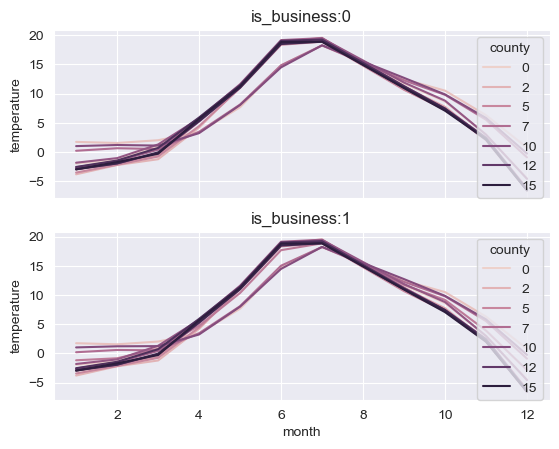

In [89]:
# 气温和地表温度与是否商业，月份，target的关系（因为气温和地表温度相似度极高，所以用温度替代）
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month.loc[i], x='month', y='temperature',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

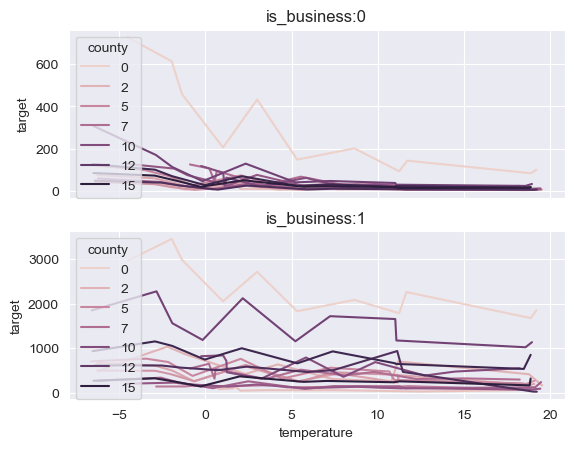

In [90]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month.loc[i], x='temperature', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

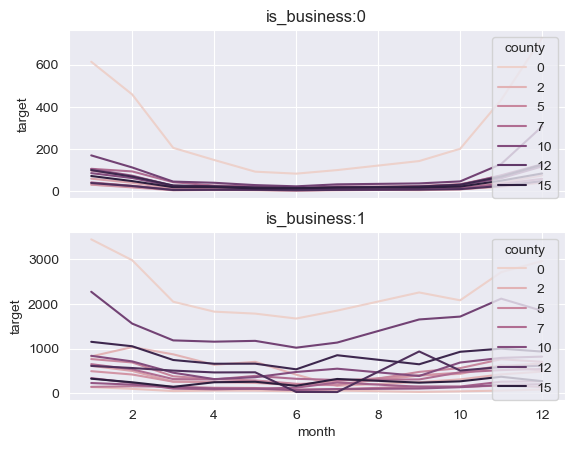

In [91]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month.loc[i], x='month', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

In [92]:
merged_no_consumption_month  = merged_no_consumption.groupby(['is_business','month','county']).mean()
merged_no_consumption_month
merged_no_consumption_month_corr = merged_no_consumption_month[['target','temperature']]
merged_no_consumption_month_corr.corr()

,target,temperature
target,1.000000,0.463629
temperature,0.463629,1.000000


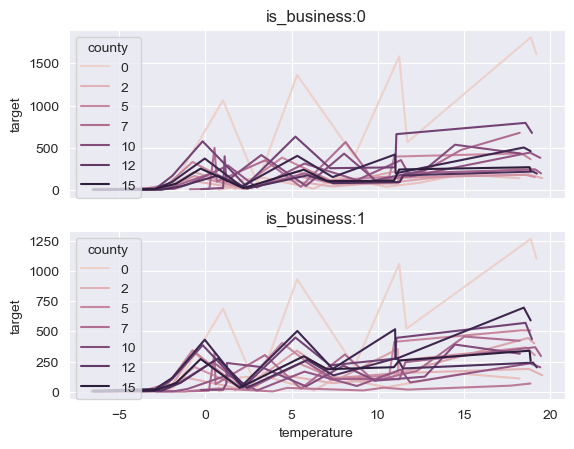

In [93]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_no_consumption_month.loc[i], x='temperature', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

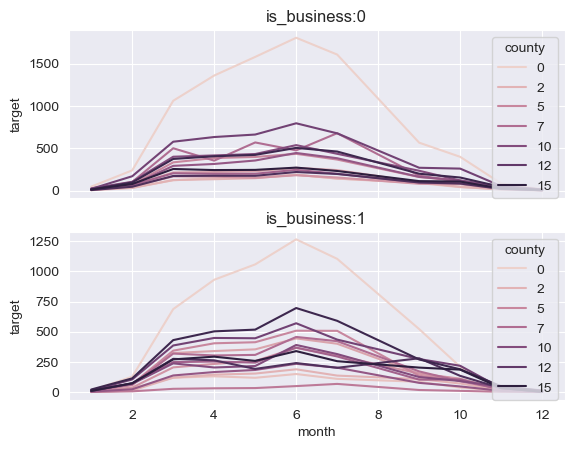

In [94]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_no_consumption_month.loc[i], x='month', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

由此可见生产目标和温度的相关性较大，消耗量与温度相关性较低，但消耗量为正相关

接下来测试降雨量,相似度极低,但不知道为什么生产量相似度依旧较高



In [95]:
merged_is_consumption_month_rain_corr = merged_is_consumption_month[['target','rain']]
merged_is_consumption_month_rain_corr.corr()

,target,rain
target,1.000000,-0.104462
rain,-0.104462,1.000000


In [96]:
merged_no_consumption_month_rain_corr = merged_no_consumption_month[['target','rain']]
merged_no_consumption_month_rain_corr.corr()

,target,rain
target,1.000000,0.266813
rain,0.266813,1.000000


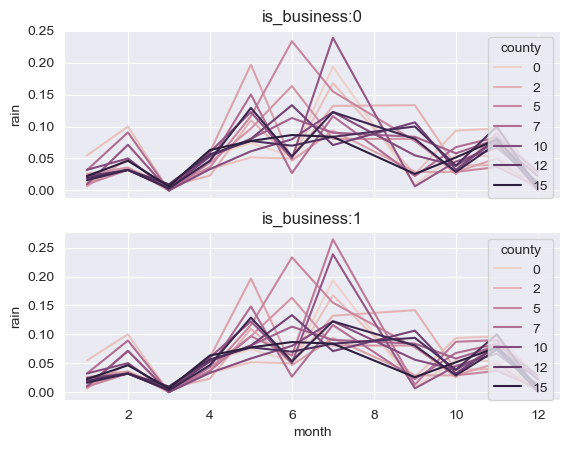

In [97]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month_rain_corr.loc[i], x='month', y='rain',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

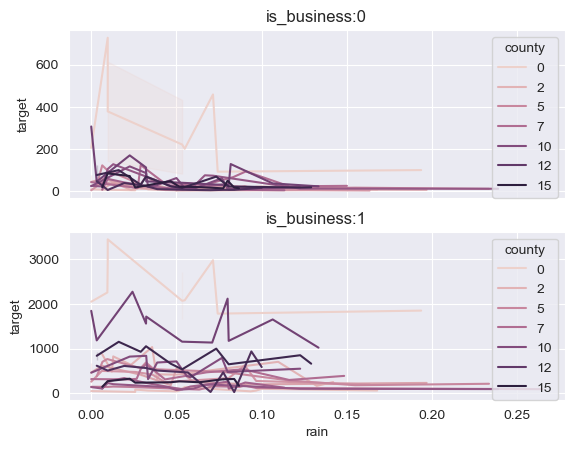

In [98]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_is_consumption_month_rain_corr.loc[i], x='rain', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

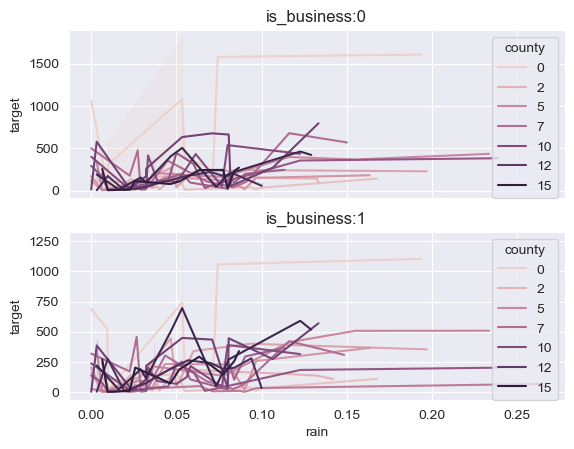

In [99]:
figure, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes.ravel()):
    sns.lineplot(data=merged_no_consumption_month_rain_corr.loc[i], x='rain', y='target',hue='county',ax=ax)
    ax.set_title('is_business:'+str(i))

In [100]:
def xiangguan(index):
    return index+'生产的相关性为:{}'.format(merged_no_consumption_month[['target',index]].corr()),index+'消耗的相关性为:{}'.format(merged_is_consumption_month[['target',index]].corr())

In [101]:
xiangguan(index='snowfall')

('snowfall生产的相关性为:            target  snowfall\ntarget    1.000000 -0.417767\nsnowfall -0.417767  1.000000',
 'snowfall消耗的相关性为:            target  snowfall\ntarget    1.000000  0.120334\nsnowfall  0.120334  1.000000')

In [102]:
def picture_no_consumption(x,y):
    figure, axes = plt.subplots(2, 1, sharex=True)
    for i, ax in enumerate(axes.ravel()):
        sns.lineplot(data=merged_no_consumption_month.loc[i], x=x, y=y,hue='county',ax=ax)
        ax.set_title('is_business:'+str(i))
def picture_is_consumption(x,y):
    figure, axes = plt.subplots(2, 1, sharex=True)
    for i, ax in enumerate(axes.ravel()):
        sns.lineplot(data=merged_is_consumption_month.loc[i], x=x, y=y,hue='county',ax=ax)
        ax.set_title('is_business:'+str(i))

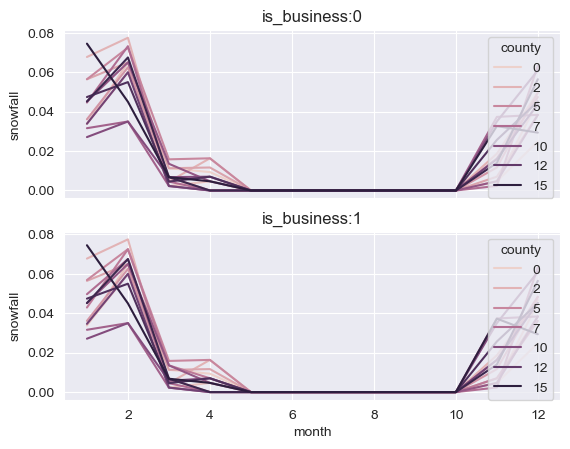

In [103]:
picture_no_consumption(x='month',y='snowfall')

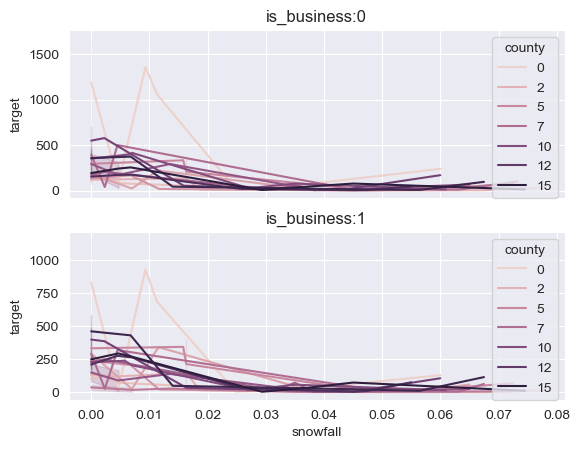

In [104]:
picture_no_consumption(x='snowfall',y='target')

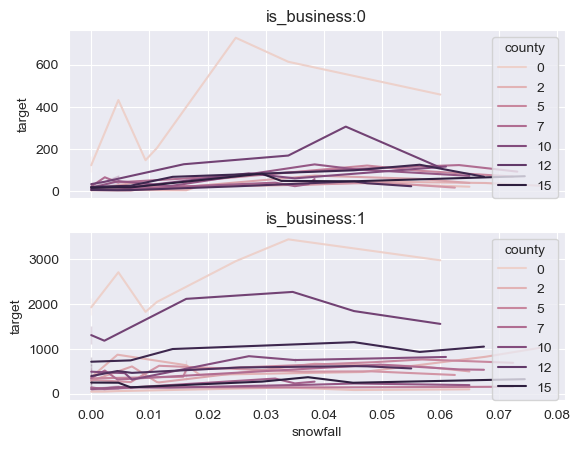

In [105]:
picture_is_consumption(x='snowfall',y='target')

In [106]:
indexs=['product_type','temperature','dewpoint','rain','snowfall','surface_pressure','cloudcover_total','cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m','shortwave_radiation','direct_solar_radiation','diffuse_radiation']
for index in indexs:
    display(xiangguan(index))

('product_type生产的相关性为:                target  product_type\ntarget        1.000000     -0.196428\nproduct_type -0.196428      1.000000',
 'product_type消耗的相关性为:                target  product_type\ntarget        1.000000     -0.297415\nproduct_type -0.297415      1.000000')

('temperature生产的相关性为:               target  temperature\ntarget       1.000000     0.463629\ntemperature  0.463629     1.000000',
 'temperature消耗的相关性为:               target  temperature\ntarget       1.000000    -0.155568\ntemperature -0.155568     1.000000')

('dewpoint生产的相关性为:           target  dewpoint\ntarget    1.00000   0.37563\ndewpoint  0.37563   1.00000',
 'dewpoint消耗的相关性为:            target  dewpoint\ntarget    1.000000 -0.140925\ndewpoint -0.140925  1.000000')

('rain生产的相关性为:          target      rain\ntarget  1.000000  0.266813\nrain    0.266813  1.000000',
 'rain消耗的相关性为:          target      rain\ntarget  1.000000 -0.104462\nrain   -0.104462  1.000000')

('snowfall生产的相关性为:            target  snowfall\ntarget    1.000000 -0.417767\nsnowfall -0.417767  1.000000',
 'snowfall消耗的相关性为:            target  snowfall\ntarget    1.000000  0.120334\nsnowfall  0.120334  1.000000')

('surface_pressure生产的相关性为:                    target  surface_pressure\ntarget            1.000000          0.213733\nsurface_pressure  0.213733          1.000000',
 'surface_pressure消耗的相关性为:                    target  surface_pressure\ntarget            1.000000         -0.160777\nsurface_pressure -0.160777          1.000000')

('cloudcover_total生产的相关性为:                    target  cloudcover_total\ntarget            1.000000         -0.502854\ncloudcover_total -0.502854          1.000000',
 'cloudcover_total消耗的相关性为:                    target  cloudcover_total\ntarget            1.000000          0.151473\ncloudcover_total  0.151473          1.000000')

('cloudcover_low生产的相关性为:                 target  cloudcover_low\ntarget          1.00000        -0.54028\ncloudcover_low -0.54028         1.00000',
 'cloudcover_low消耗的相关性为:                  target  cloudcover_low\ntarget          1.000000        0.158814\ncloudcover_low  0.158814        1.000000')

('cloudcover_mid生产的相关性为:                 target  cloudcover_mid\ntarget          1.00000        -0.28834\ncloudcover_mid -0.28834         1.00000',
 'cloudcover_mid消耗的相关性为:                 target  cloudcover_mid\ntarget          1.00000         0.09959\ncloudcover_mid  0.09959         1.00000')

('cloudcover_high生产的相关性为:                   target  cloudcover_high\ntarget           1.000000        -0.098505\ncloudcover_high -0.098505         1.000000',
 'cloudcover_high消耗的相关性为:                   target  cloudcover_high\ntarget           1.000000         0.034963\ncloudcover_high  0.034963         1.000000')

('windspeed_10m生产的相关性为:                 target  windspeed_10m\ntarget         1.000000      -0.293142\nwindspeed_10m -0.293142       1.000000',
 'windspeed_10m消耗的相关性为:                 target  windspeed_10m\ntarget         1.000000      -0.058425\nwindspeed_10m -0.058425       1.000000')

('winddirection_10m生产的相关性为:                    target  winddirection_10m\ntarget             1.00000           -0.18292\nwinddirection_10m -0.18292            1.00000',
 'winddirection_10m消耗的相关性为:                     target  winddirection_10m\ntarget             1.000000           0.042906\nwinddirection_10m  0.042906           1.000000')

('shortwave_radiation生产的相关性为:                       target  shortwave_radiation\ntarget               1.000000             0.606465\nshortwave_radiation  0.606465             1.000000',
 'shortwave_radiation消耗的相关性为:                       target  shortwave_radiation\ntarget               1.000000            -0.177223\nshortwave_radiation -0.177223             1.000000')

('direct_solar_radiation生产的相关性为:                          target  direct_solar_radiation\ntarget                  1.000000                0.603246\ndirect_solar_radiation  0.603246                1.000000',
 'direct_solar_radiation消耗的相关性为:                          target  direct_solar_radiation\ntarget                  1.000000               -0.173515\ndirect_solar_radiation -0.173515                1.000000')

('diffuse_radiation生产的相关性为:                     target  diffuse_radiation\ntarget             1.000000           0.587967\ndiffuse_radiation  0.587967           1.000000',
 'diffuse_radiation消耗的相关性为:                     target  diffuse_radiation\ntarget             1.000000          -0.178328\ndiffuse_radiation -0.178328           1.000000')

In [107]:
merged_no_consumption_month.corr().loc['target']

data_block_id             0.481506
target                    1.000000
is_consumption                 NaN
product_type             -0.196428
hour                      0.035893
datetime                  0.481517
temperature               0.463629
dewpoint                  0.375630
rain                      0.266813
snowfall                 -0.417767
surface_pressure          0.213733
cloudcover_total         -0.502854
cloudcover_low           -0.540280
cloudcover_mid           -0.288340
cloudcover_high          -0.098505
windspeed_10m            -0.293142
winddirection_10m        -0.182920
shortwave_radiation       0.606465
direct_solar_radiation    0.603246
diffuse_radiation         0.587967
latitude                  0.078958
longitude                -0.051981
year                      0.360574
day                       0.083282
Name: target, dtype: float64

In [108]:
merged_is_consumption_month.corr().loc['target']

data_block_id            -0.109610
target                    1.000000
is_consumption                 NaN
product_type             -0.297415
hour                      0.017853
datetime                 -0.109614
temperature              -0.155568
dewpoint                 -0.140925
rain                     -0.104462
snowfall                  0.120334
surface_pressure         -0.160777
cloudcover_total          0.151473
cloudcover_low            0.158814
cloudcover_mid            0.099590
cloudcover_high           0.034963
windspeed_10m            -0.058425
winddirection_10m         0.042906
shortwave_radiation      -0.177223
direct_solar_radiation   -0.173515
diffuse_radiation        -0.178328
latitude                  0.119456
longitude                 0.002746
year                     -0.066518
day                       0.004810
Name: target, dtype: float64

# 预测天气部分